# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [0]:
from pathlib import Path
import sys
import os

!mkdir car
data_folder = Path("/content/car")
os.chdir(data_folder)
!ls

In [0]:
!git clone https://github.com/udacity/CarND-LaneLines-P1
!ls

Cloning into 'CarND-LaneLines-P1'...
remote: Enumerating objects: 254, done.
remote: Total 254 (delta 0), reused 0 (delta 0), pack-reused 254
Receiving objects: 100% (254/254), 43.45 MiB | 9.75 MiB/s, done.
Resolving deltas: 100% (120/120), done.
CarND-LaneLines-P1


In [0]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

In [0]:
data_folder = Path("/content/car/CarND-LaneLines-P1/") 
os.chdir(data_folder)
!ls
test_images = "test_images"
! ls {test_images}

examples  P1.ipynb   set_git.sh   test_videos	      writeup_template.md
LICENSE   README.md  test_images  test_videos_output
solidWhiteCurve.jpg  solidYellowCurve2.jpg  solidYellowLeft.jpg
solidWhiteRight.jpg  solidYellowCurve.jpg   whiteCarLaneSwitch.jpg


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


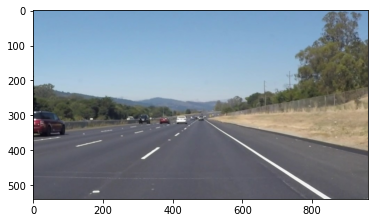

In [0]:
#reading in an image
image = mpimg.imread(os.path.join(data_folder, test_images, "solidWhiteRight.jpg"))

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [0]:
import cv2
import numpy as np


class LaneFinder:
    """
    Attributes
    ----------
        _filter_size : int
            kernel size for GaussianBlur function
        _threshold1 : int
            s. cv2.Canny
        _threshold2 : int
            s. cv2.Canny
        _rho : int
            distance resolution in pixels of the Hough grid
        _theta : float
            angular resolution in radians of the Hough grid
        _min_votes : int
            minimum number of votes (intersections in Hough grid cell)
        _min_line_length : int
            minimum number of pixels making up a line
        _max_line_gap : int
            maximum gap in pixels between connectable line segments
        _cv_color : int
            cv2.COLOR_BGR2GRAY or cv2.COLOR_RGB2GRAY
        _color : list
            color for detected and approximated lanes
        _thickness : int
            hough lines thickness
        _mean_rate : float
            means*mean_rate + current_values*(1 - mean_rate)
        _draw_all : boolean
            switch all hough lines besides approximated on and off
        _pos_intersect_ratio : int
            pos_intersect_treshold = - img.heght * pos_intersect_ratio
        _neg_intersect_ratio : int
            neg_intersect_treshold = img.heght + img.heght * pos_intersect_ratio

    Methods
    -------
    grayscale(img)
    canny(img)
    gaussian_blur(img)
    region_of_interest(img)
    _draw_means(img, lines)
    _select_lines(img, lines, color=[255, 255, 0], thickness=4)
    hough_lines(img)
    draw_lanes(img)
    """

    def __init__(   self, filter_size=7, threshold1=200, threshold2=230, 
                    rho = 4, theta = np.pi/180, min_votes = 25, min_line_length = 40, max_line_gap = 40, 
                    cv_color=cv2.COLOR_RGB2GRAY, color=[255, 0, 0], thickness=4, mean_rate = 0.9, 
                    pos_intersect_ratio=10, neg_intersect_ratio=10, draw_all=False):

        self._filter_size = filter_size # kernel size for GaussianBlur function
        self._threshold1 = threshold1 # s. cv2.Canny
        self._threshold2 = threshold2 # s. cv2.Canny

        self._rho = rho # distance resolution in pixels of the Hough grid
        self._theta = theta # angular resolution in radians of the Hough grid
        self._min_votes = min_votes     # minimum number of votes (intersections in Hough grid cell)
        self._min_line_length = min_line_length #minimum number of pixels making up a line
        self._max_line_gap = max_line_gap    # maximum gap in pixels between connectable line segments
        
        self._cv_color = cv_color #cv2.COLOR_BGR2GRAY or cv2.COLOR_RGB2GRAY
        self._color = color # color for detected and approximated lanes
        self._thickness = thickness # hough lines thickness
        self._mean_rate = mean_rate  # means*mean_rate + current_values*(1 - mean_rate)
        self._draw_all = draw_all   # switch all hough lines besides approximated on and off
        self._pos_intersect_ratio = pos_intersect_ratio # pos_intersect_treshold = - img.heght * pos_intersect_ratio
        self._neg_intersect_ratio = neg_intersect_ratio # neg_intersect_treshold = img.heght + img.heght * pos_intersect_ratio
        self._FLOAT_TRESHOLD = 0.01
        
        self._means = np.zeros((2,2), dtype=float) # slope_pos, slope_neg, intersect_pos, intersect_neg


    def grayscale(self, img):
        """Converts color image to grayscaled"""
        return cv2.cvtColor(img, self._cv_color)

    def canny(self, img):
        """Applies the Canny transform"""
        return cv2.Canny(img, self._threshold1, self._threshold2)

    def gaussian_blur(self, img):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (self._filter_size, self._filter_size), 0)

    def region_of_interest(self, img):
        """
        Applies an image mask.
        
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        imshape = img.shape
        vertices = np.array([[(0,imshape[0]),(0, imshape[0]/2+imshape[0]*0.1), 
                                (imshape[1], imshape[0]/2+imshape[0]*0.1),
                                (imshape[1],imshape[0])]], 
                                dtype=np.int32)
        mask = np.zeros_like(img)   
        
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
            
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def _draw_means(self, img, lines):
        """Computes slope and intersect means, approximates and drows lines"""
        means = np.zeros((2,2), dtype=float)
        counts = np.zeros(2, dtype=int)
        
        for line in lines:
            x1,y1,x2,y2,sl,intcpt = line
            means[int(sl < 0)] += sl,intcpt
            counts[int(sl < 0)] += 1
        
        for i in range(2):
            if counts[i]>0:
                means[i] /= counts[i]
        if abs(self._means.all()) < self._FLOAT_TRESHOLD:
            self._means = means
            #print('means init')
        for i in range(2):
            if counts[i]>0:
                self._means[i] = self._means[i]*self._mean_rate + means[i]*(1 - self._mean_rate)

            if np.isnan(self._means[i]).any():
                continue
            if abs(self._means[i,0])<self._FLOAT_TRESHOLD:
                continue
            y1 = img.shape[0]//2 + img.shape[0]//10
            y2 = img.shape[0]-1
            x1 = int((y1 - self._means[i,1])/self._means[i,0])
            x2 = int((y2 - self._means[i,1])/self._means[i,0])
            cv2.line(img, (x1, y1), (x2, y2), self._color, self._thickness)
        return img
        
    def _select_lines(self, img, lines, color=[255, 255, 0], thickness=4):
        """Removes Hough lines they are off criteria from the mean list
            can draw these lines for control"""
        _lines = []
        _short_line = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                if abs(x2-x1) < 1:
                    continue
                slope = round((y2-y1)/(x2-x1),1)
                if np.isnan(slope) or np.isinf(slope):
                    continue
                intercept = int(round(y1 - slope*x1))
                if slope > 0 and ((x1+x2<img.shape[1]) or(intercept< -img.shape[0]//self._pos_intersect_ratio)): 
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), [0, 255, 255], thickness)
                elif slope < 0 and ((x1+x2>img.shape[1]) or(intercept<(img.shape[0] + img.shape[0]//self._neg_intersect_ratio))):
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), [0, 255, 255], thickness)
                elif abs(slope) < 0.5 or abs(slope) > 0.85:
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), [0, 255, 255], thickness)
                else:
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                    _short_line = [round(x1), round(y1), round(x2), round(y2), slope, intercept]
                    _lines.append(_short_line)
        return _lines            

    def hough_lines(self, img):
        """Returns Hough lines for Canny transformed image"""
        lines = cv2.HoughLinesP(img, self._rho, self._theta, self._min_votes, np.array([]), 
            minLineLength=self._min_line_length, maxLineGap=self._max_line_gap)
        return lines


    def draw_lanes(self, img):
        """Pipeline for finding lanes"""
        tmp_img = self.grayscale(image)

        tmp_img = self.gaussian_blur(img)
        tmp_img = self.canny(tmp_img)
        tmp_img = self.region_of_interest(tmp_img)
        _lines = self.hough_lines(tmp_img)
        
        lane_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        _lines = self._select_lines(lane_img, _lines)
        tmp_img = self._draw_means(lane_img, _lines)

        return cv2.addWeighted(tmp_img, 0.8, img, 1., 0.) #[:,:,0]
        


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [0]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

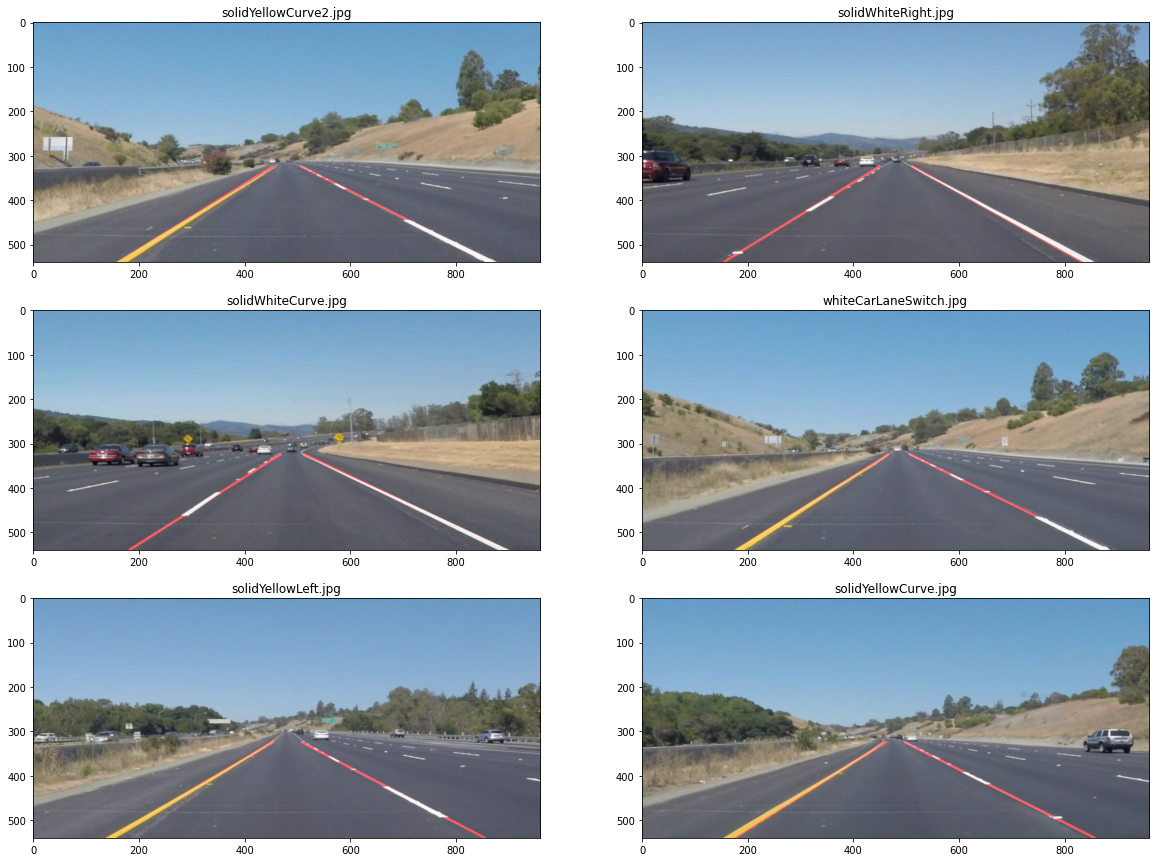

In [0]:
from math import ceil

img_in_dir = "test_images"
img_out_dir = "test_images_output"
!mkdir {img_out_dir}
img_array = os.listdir(os.path.join(data_folder, img_in_dir))
rows = ceil(len(img_array)/2.0)
plt.figure(figsize=(20,15))
for i, img_name in enumerate(img_array):
    img = mpimg.imread(os.path.join(img_in_dir, img_name))
    finder = LaneFinder()
    result_img = finder.draw_lanes(img)
    plt.subplot(rows, 2,i+1,  title=img_name), plt.imshow(result_img, aspect='auto')
    cv2.imwrite(os.path.join(data_folder, img_out_dir, img_name), result_img)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)778240/45929032 bytes (1.7%)4513792/45929032 bytes (9.8%)8634368/45929032 bytes (18.8%)12713984/45929032 bytes (27.7%)16695296/45929032 bytes (36.4%)20692992/45929032 bytes (45.1%)24682496/45929032 bytes (53.7%)28680192/45929032 bytes (62.4%)32759808/45929032 bytes (71.3%)36904960/45929032 bytes (80.4%)40878080/45929032 bytes (89.0%)45088768/45929032 bytes (98.2%)459

In [0]:
def process_clip(f_callback, file_name, base_path, inp_dir='test_videos', output_dir='test_videos_output'):
    clip_output = os.path.join(base_path, output_dir, file_name)
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(os.path.join(base_path, inp_dir, file_name)) 
    white_clip = clip1.fl_image(f_callback) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(clip_output, audio=False)

In [0]:
file_name = 'solidWhiteRight.mp4' 
finder = LaneFinder()
process_clip(finder.draw_lanes, file_name, data_folder)

[MoviePy] >>>> Building video /content/car/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video /content/car/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/car/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.66 s, sys: 336 ms, total: 8 s
Wall time: 14 s


Let's try the one with the solid white lane on the right first ...

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [0]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [0]:
file_name = 'solidYellowLeft.mp4' 
finder = LaneFinder()
process_clip(finder.draw_lanes, file_name, data_folder)

[MoviePy] >>>> Building video /content/car/CarND-LaneLines-P1/test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video /content/car/CarND-LaneLines-P1/test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:40<00:00, 16.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/car/CarND-LaneLines-P1/test_videos_output/solidYellowLeft.mp4 

CPU times: user 24.3 s, sys: 981 ms, total: 25.3 s
Wall time: 42.6 s


In [0]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [0]:
file_name = 'challenge.mp4' 
finder = LaneFinder()
process_clip(finder.draw_lanes, file_name, data_folder)

[MoviePy] >>>> Building video /content/car/CarND-LaneLines-P1/test_videos_output/challenge.mp4
[MoviePy] Writing video /content/car/CarND-LaneLines-P1/test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:29<00:00,  8.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/car/CarND-LaneLines-P1/test_videos_output/challenge.mp4 

CPU times: user 15.7 s, sys: 615 ms, total: 16.3 s
Wall time: 32.4 s


In [0]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(challenge_output))